# Importing Necessary Libraries

In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 28.7 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires flatbuffers~=1.12.0, but you have flatbuffers 23.1.4 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is in

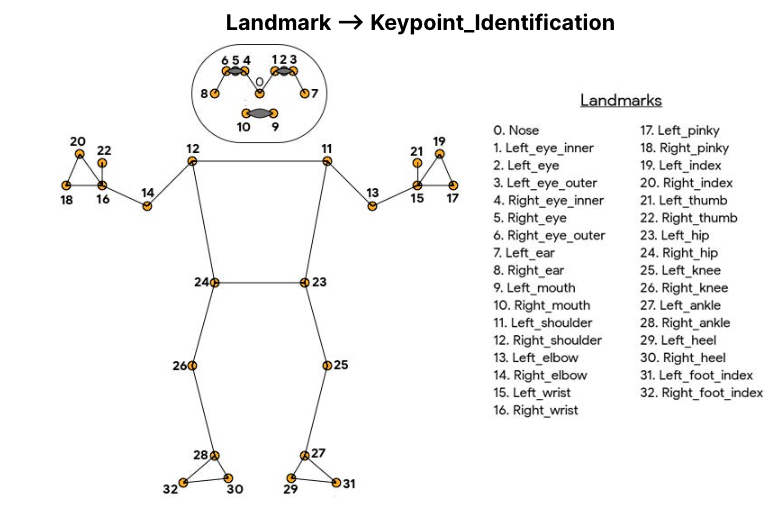

In [1]:
import matplotlib.pyplot as plt
from time import time
import mediapipe as mp
import cv2 as cv

# Init Project

In [2]:
mpPose = mp.solutions.pose

In [3]:
pose = mpPose.Pose(
    static_image_mode=True,
    min_detection_confidence=0.3,
    model_complexity=2
)

I0000 00:00:1702455896.416921       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1 Max


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
mpDraw = mp.solutions.drawing_utils

# Read & Perform

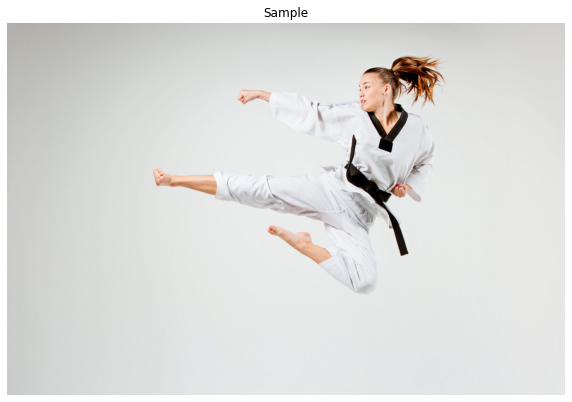

In [7]:
image = cv.imread('/kaggle/input/posedetectiondataset/01.jpg')
plt.figure(figsize=[10, 10])
plt.title('Sample')
plt.axis('off')
plt.imshow(image[:, :, ::-1])
plt.show()

In [8]:
result = pose.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))

if result.pose_landmarks:
    for i in range(2):
        print(mpPose.PoseLandmark(i).name)
        print(result.pose_landmarks.landmark[mpPose.PoseLandmark(i).value])


NOSE
x: 0.6385153532028198
y: 0.20057985186576843
z: -0.19952423870563507
visibility: 0.9999887943267822

LEFT_EYE_INNER
x: 0.6453086137771606
y: 0.18448516726493835
z: -0.20634575188159943
visibility: 0.9999717473983765



In [9]:
imgHeight, imgWidth, _ = image.shape

In [10]:
if result.pose_landmarks:
    for i in range(2):
        print(mpPose.PoseLandmark(i).name)
        print(result.pose_landmarks.landmark[mpPose.PoseLandmark(i).value].x * imgWidth)
        print(result.pose_landmarks.landmark[mpPose.PoseLandmark(i).value].y * imgHeight)
        print(result.pose_landmarks.landmark[mpPose.PoseLandmark(i).value].z * imgWidth)
        print(result.pose_landmarks.landmark[mpPose.PoseLandmark(i).value].visibility)


NOSE
1634.5993041992188
342.3898071348667
-510.7820510864258
0.9999887943267822
LEFT_EYE_INNER
1651.9900512695312
314.91618052124977
-528.2451248168945
0.9999717473983765


In [11]:
imgCopy = image.copy()

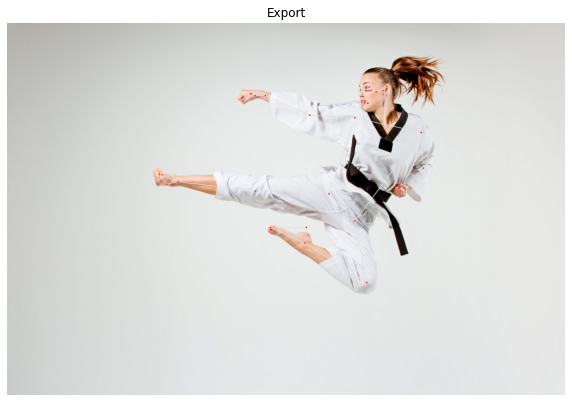

In [12]:
if result.pose_landmarks:
    mpDraw.draw_landmarks(
        image=imgCopy,
        landmark_list=result.pose_landmarks,
        connections=mpPose.POSE_CONNECTIONS
    )
    fig = plt.figure(figsize=[10, 10])
    plt.title('Export')
    plt.axis('off')
    plt.imshow(imgCopy[:, :, ::-1])
    plt.show()


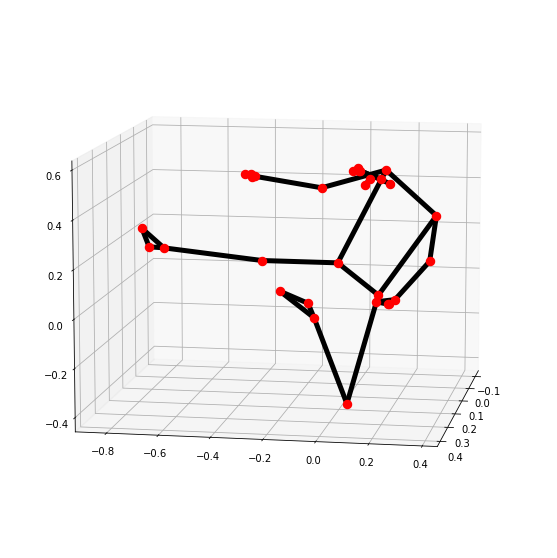

In [13]:
mpDraw.plot_landmarks(
    result.pose_world_landmarks,
    mpPose.POSE_CONNECTIONS
)

# Detect Pose

In [14]:
def detectPose(image, pose, display=True):
    OutputImage = image.copy()
    imageRGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    results = pose.process(imageRGB)
    imgHeight, imgWidth, _ = image.shape
    landmarks = []

    if results.pose_landmarks:
        mpDraw.draw_landmarks(
            image=OutputImage,
            landmark_list=results.pose_landmarks,
            connections=mpPose.POSE_CONNECTIONS
        )
        for landmark in results.pose_landmarks.landmark:
            landmarks.append(
                (int(landmark.x * imgWidth),
                 int(landmark.y * imgHeight),
                 int(landmark.z * imgWidth))
            )
    if display:
        plt.figure(figsize=[22, 22])

        plt.subplot(211)
        plt.title('Original')
        plt.axis('off')
        plt.imshow(image[:, :, ::-1])

        plt.subplot(212)
        plt.title('Output')
        plt.axis('off')
        plt.imshow(OutputImage[:, :, ::-1])

        mpDraw.plot_landmarks(results.pose_world_landmarks, mpPose.POSE_CONNECTIONS)

    else:
        return OutputImage, landmarks

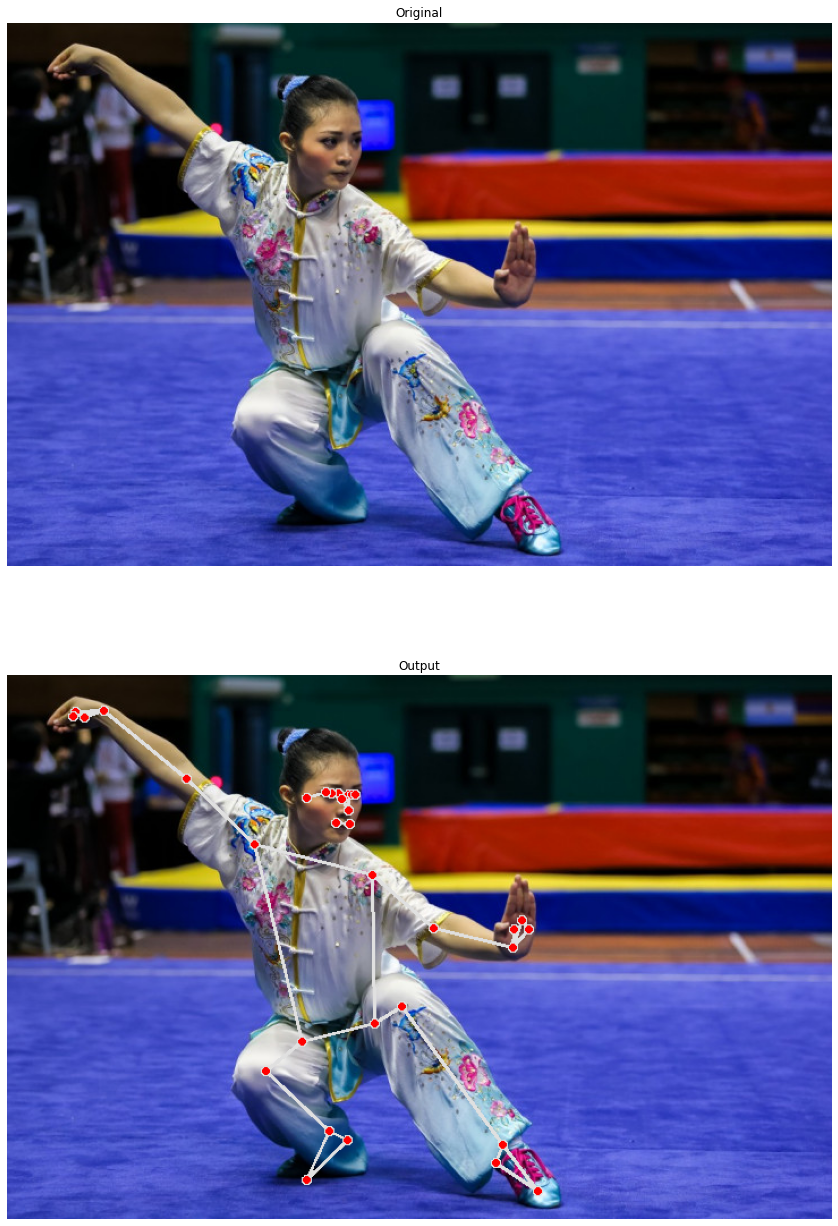

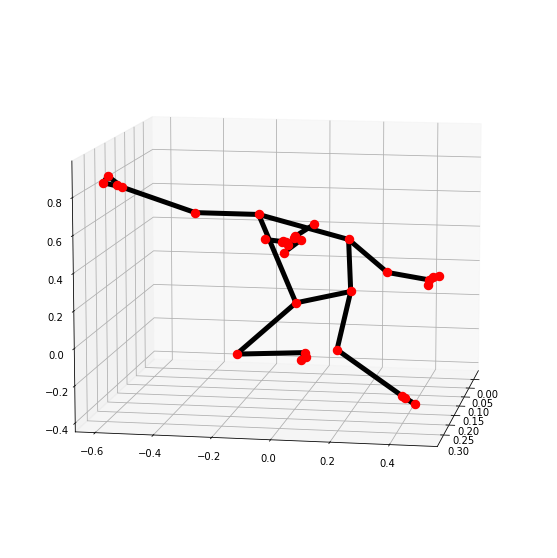

In [15]:
img = cv.imread('/kaggle/input/posedetectiondataset/3.jpg')
detectPose(img, pose, display=True)

# POSE Detection - Camera

In [16]:
poseVideo = mpPose.Pose(
    static_image_mode=False,
    min_detection_confidence=0.5,
    model_complexity=1
)

video = cv.VideoCapture(0)

# cv.namedWindow('Pose', cv.WINDOW_NORMAL)
video.set(3, 1280)
video.set(4, 960)
time1 = 0

while video.isOpened():
    ok, frame = video.read()

    if not ok:
        break

    frame = cv.flip(frame, 1)
    frameHeight, frameWidth, _ = frame.shape
    frame = cv.resize(frame, (int(frameWidth * (640 / frameHeight)), 640))
    frame, _ = detectPose(frame, poseVideo, display=False)
    time2 = time()
    T = time2 - time1

    if T > 0:
        framesPerSecond = 1.0 / T
        cv.putText(
            frame,
            'FPS: {}'.format(int(framesPerSecond)), (10, 30),
            cv.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3
        )

    time1 = time2
    cv.imshow('Pose New', frame)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break

video.release()
# cv.destroyAllWindows()

[ WARN:0] global /tmp/pip-req-build-jpmv6t9_/opencv/modules/videoio/src/cap_v4l.cpp (890) open VIDEOIO(V4L2:/dev/video0): can't open camera by index
